# Midterm - Israel-Palestine Conflict
The dataset consists of a little over 3,000 news article headlines, descriptions, and dates related to the Israel-Palestine Conflict. They are sourced from Al Jazeera, a Qatar based news outlet, and span the years 2021 to 2023.

Data Source: https://www.kaggle.com/datasets/emirslspr/israel-hamas-conflict-news-dataset

# Setup

In [252]:
# Import packages and load model
import spacy
from collections import Counter
from spacy.matcher import Matcher
from spacy.tokens import Doc
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import seaborn as sns
# sns.set()
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()# Visualise inside a notebook
# nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_md")

# Load Dataset

In [3]:
news = pd.read_csv("data/news_data.csv")

# View Shape
print(news.shape)

# Getter Extension: Remove stop words and punctuation
def get_clean_tokens(doc):
    return [token for token in doc if not token.is_stop and not token.is_punct]

# Remove U+000AD soft-hyphen
def remove_hyphen(text):
    return text.replace("\xad", "")


(3338, 3)


In [71]:
# Add Article ID, Type, Date, and Sentiment Extensions
Doc.set_extension("article_id", default=None)
Doc.set_extension("type", default=None)
Doc.set_extension("date", default=None)
Doc.set_extension("sentiment", default=None)

In [57]:
# Add index as column
news["article_id"] = news.index
news.head(5)

,headline,description,date,article_id
0,Gaza’s jour­nal­ists: ‘Tar­gets’ or ‘ca­su­al­...,Gaza’s jour­nal­ists are be­ing killed at an u...,23-12-2023,0
1,Is­rael or­ders ‘death cor­ri­dor’ evac­u­a­ti...,Hun­dreds of Pales­tini­ans were forced to eva...,23-12-2023,1
2,"Is­rael’s war on Gaza: List of key events, day 78",UN Se­cu­ri­ty Coun­cil pass­es res­o­lu­tion ...,23-12-2023,2
3,US ac­cus­es Iran of be­ing ‘deeply in­volved’...,White House says Tehran is pro­vid­ing Yemeni ...,23-12-2023,3
4,Is­raeli forces con­tin­ue at­tacks amid crit­...,The wa­tered-down res­o­lu­tion boost­ing aid ...,23-12-2023,4


In [68]:
# Get Headline and Description columns separately with date and article_id
headline_texts = news[['article_id', 'headline', 'date']].values.tolist()
descriptions = news[['article_id', 'description', 'date']].values.tolist()

# Make a 2d list with text and an context dictionary (article_id, date, type))
headline_list = [[headline, {"article_id": article_id, "date": date, "type": "headline"}] for article_id, headline, date in headline_texts]
description_list = [[description, {"article_id": article_id, "date": date, "type": "description"}] for article_id, description, date in descriptions]

In [69]:
# Remove U+000AD soft-hyphen
headlines = [(remove_hyphen(headline), context) for headline, context in headline_list]
descriptions = [(remove_hyphen(description), context) for description, context in description_list]

In [84]:
# Process Headlines and Descriptions into pipeline with type, date, and sentiment context
sentiment_analyzer = SentimentIntensityAnalyzer()
docs = []
for doc, context in nlp.pipe(headlines, as_tuples=True):
    doc._.article_id = context["article_id"]
    doc._.type = "headline"
    doc._.date = pd.to_datetime(context["date"], format="%d-%m-%Y")
    doc._.sentiment = sentiment_analyzer.polarity_scores(doc.text)
    docs.append(doc)
    
for doc, context in nlp.pipe(descriptions, as_tuples=True):
    doc._.article_id = context["article_id"]
    doc._.type = "description"
    doc._.date = pd.to_datetime(context["date"], format="%d-%m-%Y")
    doc._.sentiment = sentiment_analyzer.polarity_scores(doc.text)
    docs.append(doc)

# Get Word Counts

In [85]:
# Count unique words in headlines and descriptions
word_counts = Counter()

for doc in docs:
    word_counts.update([token.text for token in get_clean_tokens(doc)])
    
word_counts.most_common(20)

[('Israel', 2475),
 ('Gaza', 2208),
 ('Israeli', 1759),
 ('Palestinian', 1043),
 ('Palestinians', 811),
 ('war', 794),
 ('Hamas', 627),
 ('killed', 519),
 ('says', 505),
 ('West', 427),
 ('Bank', 407),
 ('forces', 354),
 ('occupied', 330),
 ('Al', 318),
 ('attack', 290),
 ('Palestine', 288),
 ('UN', 282),
 ('attacks', 260),
 ('day', 229),
 ('amid', 221)]

# #1 - Looking for Bias: Word Usage
As Al Jazeera is a Qatar based and potentially supported news outlet, the question appeared of analyzing the potential bias in their articles. Today (04/18/24), [Qatar stated](https://www.bbc.com/news/world-middle-east-68835645) that they have had politicians misusing their role of mediator between Israel and Palestine. This gives even more merit to potential of bias in these news articles.

Initially, the count of a curated list of words was found. From this, it can be seen that Israel/Israeli and Gaza are mentioned almost triple the amount of times as Palestine/Palestinian. If Qatar and Al Jazeera are favoring Palestine, this could be an indication that they are favoring discussion of Israel and their actions over Palestine. This could also be coincidental, so more analyzing should be done.

In [77]:
bias_words = pd.DataFrame(word_counts.items(), columns=["word", "count"])

filter_list = ['UN', 'Israel', 'Israeli', 'Palestine', 'Palestinian', 'Palestinians', 'Jewish', 'Hamas', 'Gaza', 'Netanyahu', 'Jerusalem', 'West', 'Bank', 'IDF']

bias_filtered = bias_words[bias_words["word"].isin(filter_list)].sort_values(by="count", ascending=False)
bias_filtered

,word,count
4,Israel,2475
0,Gaza,2208
25,Israeli,1759
97,Palestinian,1043
10,Palestinians,811
92,Hamas,627
48,West,427
348,Bank,407
135,Palestine,288
39,UN,282


# #2 - Looking for Bias: Adjectives
Continuing the quest for finding bias in these articles, the adjectives used to describe proper nouns were found. This was done by runing a SpaCy matcher against the tokens, and counting the most common usages.

One interesting findings from this experiment is the mention of 'young' and 'old' Palestinians, which could potentially indicate a lean towards making readers emotionally sensitive or biased toward Palestinians. Another finding is the mention of 'right' Israelis, which is potentially speaking of political leaning.

In [270]:
# Create adjective word matcher
adj_matcher = Matcher(nlp.vocab)

# Match on adjective words before and after named entities
pattern = [
    [{"POS": "ADJ"}, {"POS": "PROPN"}],
    [{"POS": "PROPN"}, {"POS": "ADJ"}],
    # [{"POS": "ADJ"}, {"POS": "NOUN"}],
    [{"POS": "NOUN"}, {"POS": "ADJ"}],
]

adj_matcher.add("ADJ_PATTERN", pattern)

# Find most common adjectives
adj_matches_found = Counter()

for doc in docs:
    matches = adj_matcher(doc)
    if matches:
        for match_id, start, end in matches:
            span = doc[start:end]
            adj_matches_found.update([span.text])
            
adj_matches_found.most_common(20)


[('occupied West', 43),
 ('southern Gaza', 36),
 ('northern Gaza', 30),
 ('Israeli PM', 16),
 ('Palestinian Islamic', 10),
 ('central Gaza', 9),
 ('southern Israel', 9),
 ('Jazeera Arabic', 7),
 ('south Lebanon', 7),
 ('many Palestinians', 7),
 ('southern Lebanon', 7),
 ('US military', 7),
 ('Top US', 7),
 ('south Gaza', 6),
 ('young Palestinians', 6),
 ('old Palestinian', 5),
 ('more Palestinians', 5),
 ('Arab Americans', 5),
 ('Several Palestinians', 5),
 ('right Israelis', 5)]

# #3 - Analyzing Average Sentiment
Another major question that is raised when looking at this dataset is sentiment. With such a controversial and severe topic, there will most likely be varying levels of sentiment.

To begin this analysis, the sentiment for each document is found during the SpaCy pipeline process. Then, the headline and description documents are separted out into lists.

The average is then found of each. This allow us to see the general sentiment, as well as if there is any major difference between headline and description which could indicate 'clickbait' titles.

In [80]:
# Get avg compound sentiment for headlines and descriptions
headline_compound_sentiment = [doc._.sentiment["compound"] for doc in docs if doc._.type == "headline"]
description_compound_sentiment = [doc._.sentiment["compound"] for doc in docs if doc._.type == "description"]

avg_headline_sentiment = sum(headline_compound_sentiment) / len(headline_compound_sentiment)
avg_description_sentiment = sum(description_compound_sentiment) / len(description_compound_sentiment)

print(f"Average Headline Sentiment: {avg_headline_sentiment}")
print(f"Average Description Sentiment: {avg_description_sentiment}")


Average Headline Sentiment: -0.2993361593768712
Average Description Sentiment: -0.3042775913720772


# #4 - Sentiment over Time
As the date of the articles is included in the dataset, it was thought to analyze the change in sentiment over the time that the articles were published.

This was accomplished by grouping the sentiments of headlines and descriptions separately, and plotting them on a line graph over time. The graphs were split into year periods due to the large amount of articles and the increased frequency of publishing towards the end of 2023.

From these plots, the sentiment trends, as well as the difference between headline and description sentiment per article can be analyzed. It is a little hard to analyze the overall trned, as the points are on a per article basis. This makes very fine grained analysis possible, but to see a more long-term sentiment change, the articles should be grouped into date ranges or buckets.

The mean sentiment value of headlines and descriptions is also displayed in a pivot table below the graphs.

In [88]:
sentiment_df = pd.DataFrame({
    "date": [doc._.date for doc in docs],
    "sentiment": [doc._.sentiment["compound"] for doc in docs],
    "type": [doc._.type for doc in docs]
})

sentiment_df = sentiment_df.set_index("date")

head_sent_df = sentiment_df[sentiment_df["type"] == "headline"]
desc_sent_df = sentiment_df[sentiment_df["type"] == "description"]


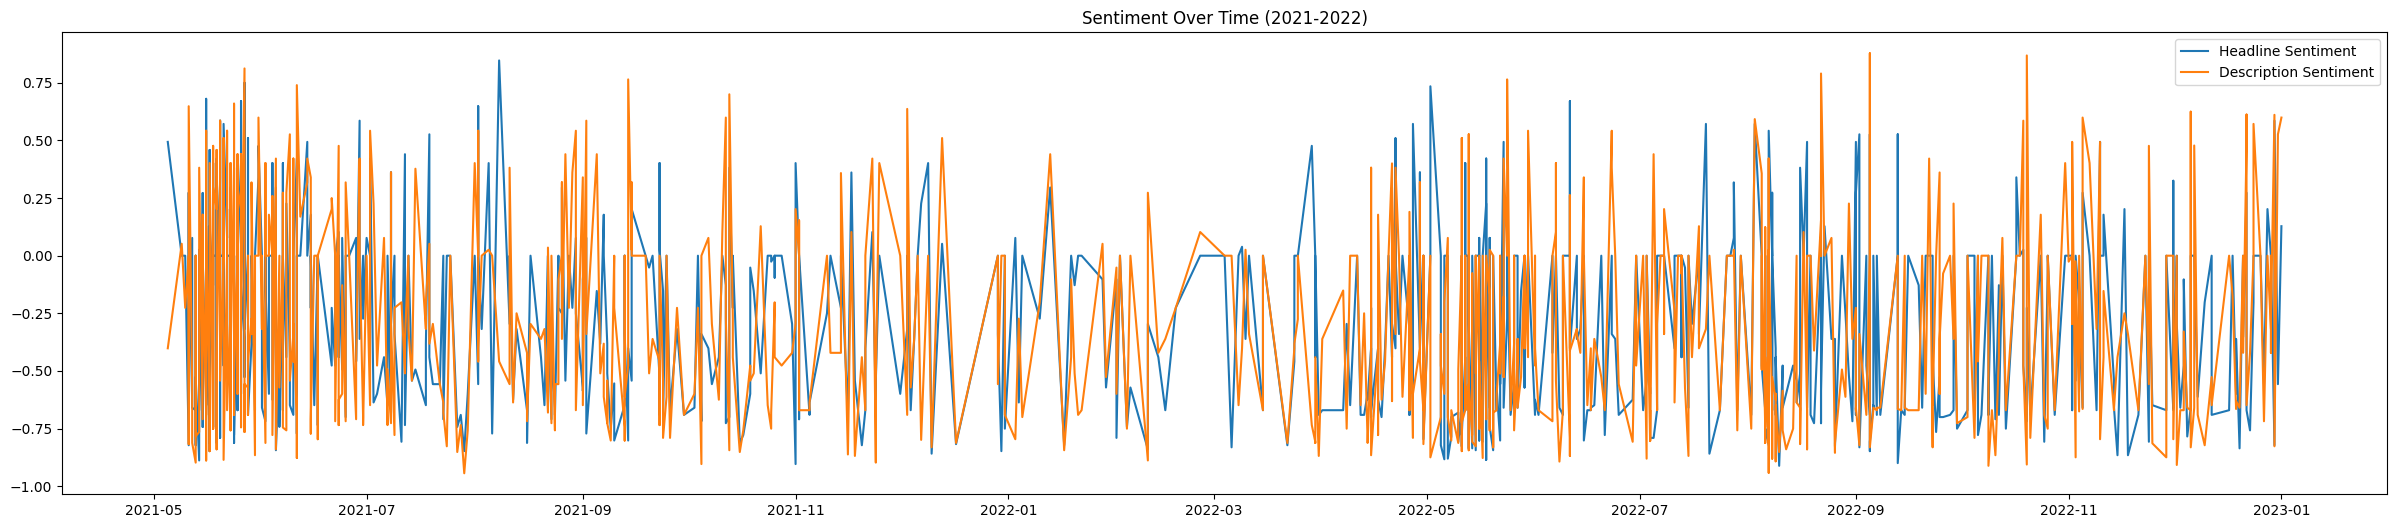

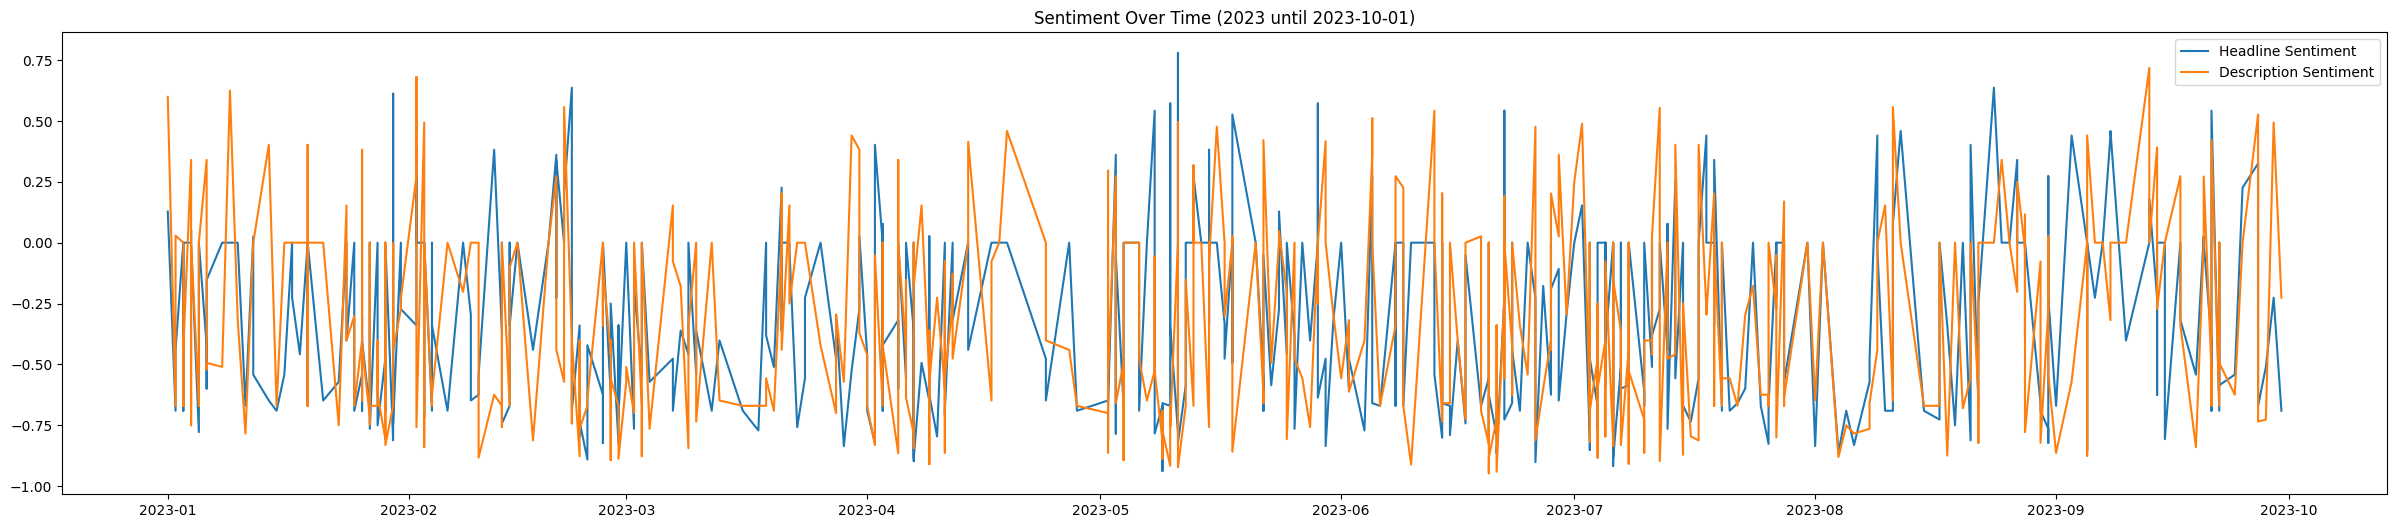

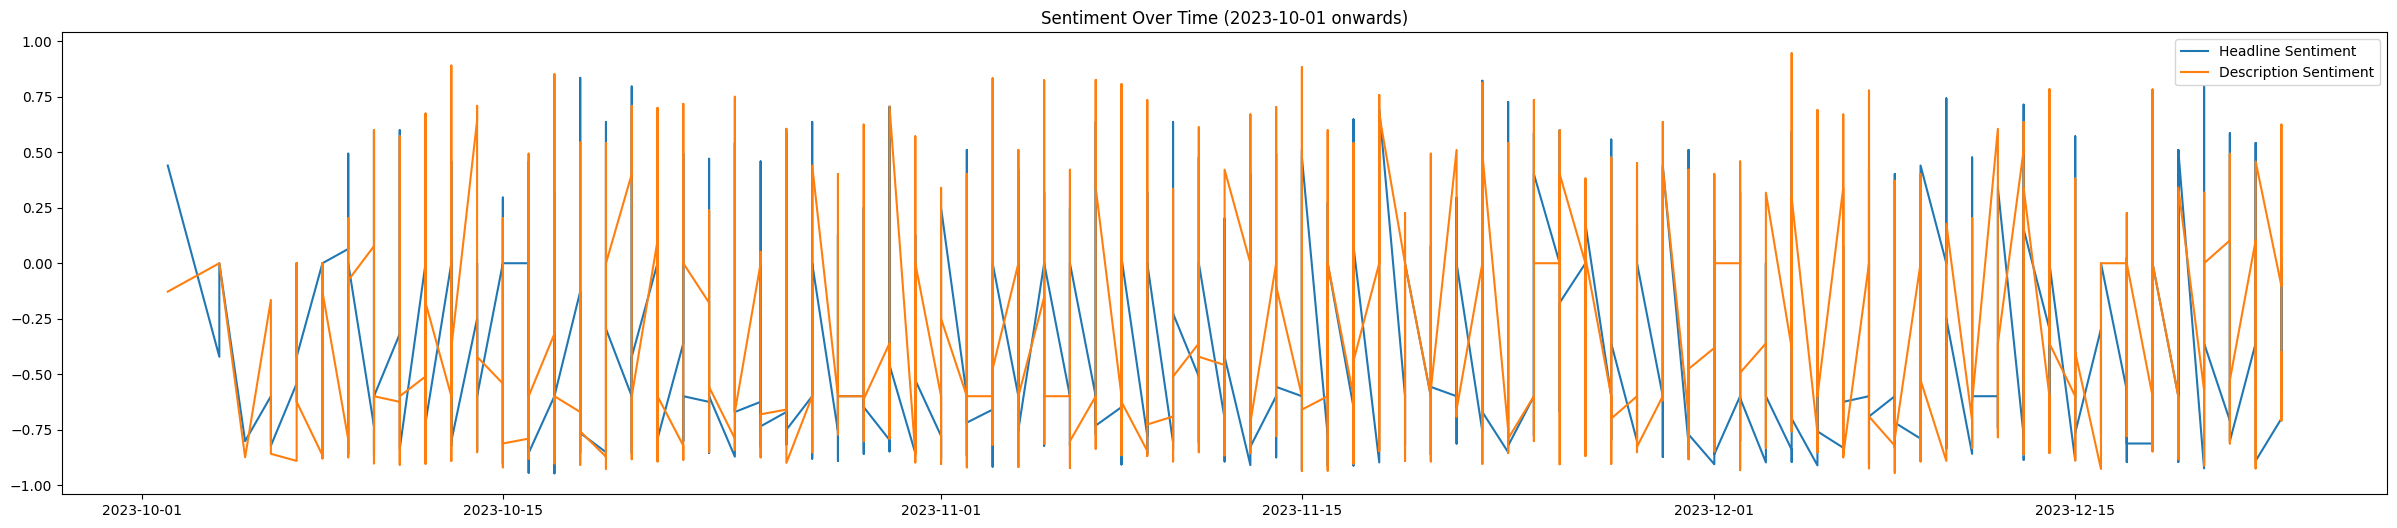

In [271]:
# Plot sentiment over time from 2021-2023
fig_sent_21, ax_sent_21 = plt.subplots(figsize=(30, 6))
fig_sent_23, ax_sent_23 = plt.subplots(figsize=(30, 6))

head_sent_21 = head_sent_df[(head_sent_df.index >= "2021-01-01") & (head_sent_df.index <= "2023-01-01")]
desc_sent_21 = desc_sent_df[(desc_sent_df.index >= "2021-01-01") & (desc_sent_df.index <= "2023-01-01")]

ax_sent_21.plot(head_sent_21.index, head_sent_21["sentiment"], label="Headline Sentiment")
ax_sent_21.plot(desc_sent_21.index, desc_sent_21["sentiment"], label="Description Sentiment")
ax_sent_21.set_title("Sentiment Over Time (2021-2022)")
ax_sent_21.legend()

# Plot sentiment over time from 2023 until 2023-10-01
head_sent_23 = head_sent_df[(head_sent_df.index >= "2023-01-01") & (head_sent_df.index <= "2023-10-01")]
desc_sent_23 = desc_sent_df[(desc_sent_df.index >= "2023-01-01") & (desc_sent_df.index <= "2023-10-01")]

ax_sent_23.plot(head_sent_23.index, head_sent_23["sentiment"], label="Headline Sentiment")
ax_sent_23.plot(desc_sent_23.index, desc_sent_23["sentiment"], label="Description Sentiment")
ax_sent_23.set_title("Sentiment Over Time (2023 until 2023-10-01)")
ax_sent_23.legend()

# Plot sentiment over time from 2023-10-01 onwards
fig_sent_23_10, ax_sent_23_10 = plt.subplots(figsize=(30, 6))

head_sent_23_10 = head_sent_df[head_sent_df.index >= "2023-10-01"]
desc_sent_23_10 = desc_sent_df[desc_sent_df.index >= "2023-10-01"]

ax_sent_23_10.plot(head_sent_23_10.index, head_sent_23_10["sentiment"], label="Headline Sentiment")
ax_sent_23_10.plot(desc_sent_23_10.index, desc_sent_23_10["sentiment"], label="Description Sentiment")
ax_sent_23_10.set_title("Sentiment Over Time (2023-10-01 onwards)")
ax_sent_23_10.legend()

In [83]:
# Compare sentiment between headlines and descriptions in table
sentiment_comparison = pd.pivot_table(sentiment_df, index="type", values="sentiment", aggfunc="mean")
sentiment_comparison

,sentiment
type,
description,-0.304278
headline,-0.299336


# #5 - Finding Articles With Biggest Sentiment Changes
Continuing the analysis of sentiment, the difference in sentiment between each article and the article before it is calculated.

This is a very interesting experiment, as the thought was to potentially find when big events in the conflict happened or why sentiment changes so much.

The results show that there are some very major sentiment changes between some neighboring articles, much larger than expected. Some of these articles did line up with major events in the conflict. For example, Article ID 1572, where the day before Hamas launched a surprise attack on Israel, and thus the article the day after on a different topic had a much better sentiment.

In [93]:
# Find biggest changes in headline sentiment over time
# Get headline type and sort by index
sent_head_sorted = sentiment_df[sentiment_df["type"] == "headline"].sort_index()

# Calulate sentiment change from previous headline
sent_head_sorted["sentiment_change"] = sent_head_sorted["sentiment"].diff()
sent_head_sorted["sentiment_change_abs"] = sent_head_sorted["sentiment_change"].abs()

sentiment_change = sent_head_sorted.sort_values(by="sentiment_change_abs", ascending=False)
sentiment_change.head(10)

,sentiment,type,article_id,sentiment_change,sentiment_change_abs
date,,,,,
2023-12-20,-0.9246,headline,54,-1.7210,1.7210
2021-08-08,0.8473,headline,3017,1.6190,1.6190
2023-12-20,0.7964,headline,51,1.6090,1.6090
2023-05-11,0.7783,headline,2159,1.6008,1.6008
2023-10-18,0.8357,headline,1572,1.5787,1.5787
2023-10-20,0.7964,headline,1511,1.5470,1.5470
2023-10-27,0.6369,headline,1315,1.5176,1.5176
2023-10-30,-0.7964,headline,1266,-1.5012,1.5012
2023-11-23,0.7269,headline,597,1.4919,1.4919


# #6 - Does Wording Correlate with Sentiment Change?
After finding the large changes in sentiment, it was natural to question what wording affected the change. So, the headline text for each article in the previous result along with the previous headline text it was compared against was found and printed out.

From this, we can do an eye test of why some headlines had a much more positive or negative sentiment score than the one before it. With more time, it would be beneficial to analyze these headlines more finely to gain more insight.

From the eye test, it can be easily seen that headlines with words like 'war', 'death', etc. had a much worse sentiment score and therefore the headline after it saw a great increase.

In [158]:
# Compare headline with headline before it from sentiment_change
def compare_docs(article_id, docs):
    current = None
    previous = None
    
    for doc in docs:
        if doc._.article_id == article_id and doc._.type == "headline":
            current = doc
        elif doc._.article_id == article_id - 1 and doc._.type == "headline":
            previous = doc
        if current and previous:
            break
    
    return previous, current

# Apply compare_docs to sentiment_change rows (axis=1)
top_changes = sentiment_change[:10]
sent_compare = top_changes.apply(lambda x: compare_docs(x["article_id"], docs), axis=1)

In [277]:
# Put pairs into new df with two columns
compare_results = pd.DataFrame(sent_compare.tolist(), index=sent_compare.index)
top_changes.loc[:, "previous"] = compare_results[0]
top_changes.loc[:, "current"] = compare_results[1]

for idx, row in top_changes.iterrows():
    print(f"Sentiment Change: {row['sentiment_change']}")
    print(f"Article ID: {row['article_id']}")
    print(f"Previous: {row['previous'].text}")
    print(f"Current: {row['current'].text}")
    print("\n")

Sentiment Change: -1.721
Article ID: 54
Previous: Women and children among dead in Israeli attacks in south Gaza
Current: Israel-Hamas war updates: Death toll in Gaza hits 20,000 as fighting rages


Sentiment Change: 1.6190000000000002
Article ID: 3017
Previous: Palestinian journalists claim pressure by PA amid crackdown
Current: Students in Gaza celebrate passing final exams despite war trauma


Sentiment Change: 1.609
Article ID: 51
Previous: Israel’s war on Gaza: List of key events, day 75
Current: ‘No safe place’: Jenin’s Freedom Theatre raided, daubed with Star of David


Sentiment Change: 1.6008
Article ID: 2159
Previous: Israel’s prime target: What is Palestinian Islamic Jihad?
Current: One year on, family, friends, and fans honour Shireen Abu Akleh


Sentiment Change: 1.5787
Article ID: 1572
Previous: Where in Gaza is al-Ahli Arab Hospital hit amid war with Israel?
Current: ‘It’s clear Macron’s party has a very strong anti-Palestinian position’


Sentiment Change: 1.54700000000

# Word Embedings

## Setup

In [205]:
def get_clean_token_strings(doc):
    return [f'{str(token).lower()}' for token in doc if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit]

In [206]:
cleaned_tokens = [get_clean_token_strings(doc) for doc in docs]

In [207]:
# Train word2vec model
model = Word2Vec(sentences=cleaned_tokens, vector_size=16, window=2, sg=1, min_count=3)

for index, word in enumerate(model.wv.index_to_key):
    if index == 5:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)}: {word}")

word #0/2912: israel
word #1/2912: gaza
word #2/2912: israeli
word #3/2912: palestinian
word #4/2912: war


In [209]:
# Save to TSV
def write_tsv():
    with open('data/midtermVectors.tsv', 'w') as v:
        with open('data/midtermMeta.tsv', 'w') as m:
            for word in model.wv.index_to_key:
                if word != '' and word != ' ':
                    vector = model.wv.get_vector(word)
                    vector_str = '\t'.join([str(num) for num in vector])
                    v.write(f'{vector_str}\n')
                    m.write(f'{word}\n')
                
write_tsv()

## #1 - TensorFlow Projector Findings
Using the TensorFlow Projector, there were some interesting connections found.

PCA:
- 'hamas' closely linked with 'war'
- 'israel' is much closer to 'hamas' than 'palestine', which is interesting as they are a Palestinian group but are more likely to be featured in the same sentence in opposition of Israel.

T-SNE:
- 'israel': 'captives'
- 'raid': 'jenin', 'army', 'forces', 'kill/s'



### TensorFlow Images
!['Aid'](/img/midterm_aid.png)
!['PCA Israel'](/img/midterm_pca_israel.png)
!['PCA Palestine'](/img/midterm_pca_palestine.png)

## #2 - LDA Topics
An LDA experiment was run on the dataset to group terms into three (3) different topics. This is an interesting way to break down the corpus from ideas related to the Israel-Palestine conflict even furthur into more detailed topics.

The three topics can be roughly generalized as:
1. War events, attacks, and victims of the conflict in Gaza, focusing on Israeli actions.
2. General or peaceful topics of the conflict.
3. Locational events or discussion within the conflict.

### Finding What Amount of Topics to Use

In [257]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf
# Create Gensim Dictionary
dictionary = Dictionary(cleaned_tokens)
# Filter Extremes
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create Gensim Corpus using Dictionary
corpus = [dictionary.doc2bow(doc) for doc in cleaned_tokens]

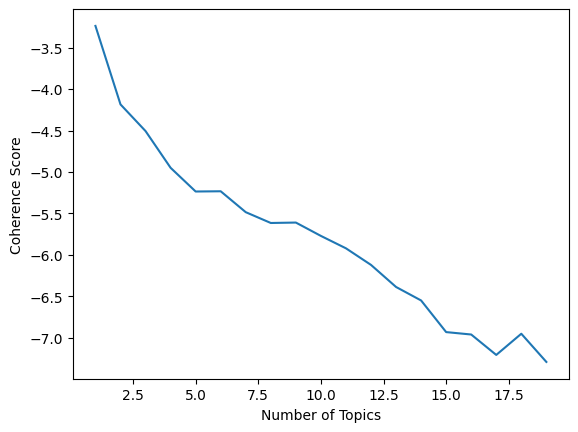

In [261]:
# Compute U_Mass Topics Score
um_topics = []
um_score = []
for i in range(1,20,1):
    # Train Model
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers =6, passes=10, random_state=100)
    # Compute Coherence Score
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    um_topics.append(i)
    um_score.append(cm.get_coherence())
_=plt.plot(um_topics, um_score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

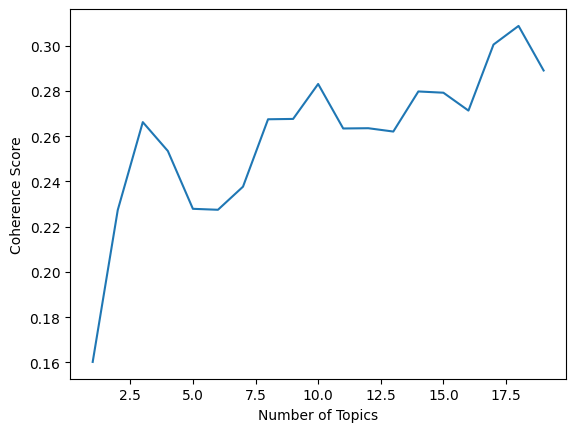

In [262]:
# Compute C_v Topics Score
cv_topics = []
cv_score = []
for i in range(1,20,1):
    # Train LDA Model
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers=4, passes=10, random_state=100)
    # Compute Coherence Score
    cm = CoherenceModel(model=lda_model, texts=cleaned_tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
    cv_topics.append(i)
    cv_score.append(cm.get_coherence())
_=plt.plot(cv_topics, cv_score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

### Two/Three Topics Found as Best, Training with 3

In [266]:
# Two/Three Topics Seems Best
# Train LDA Model with 2 Topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers=6, passes=10, random_state=100)
lda_model.print_topics(-1)

[(0,
  '0.084*"gaza" + 0.074*"israel" + 0.032*"war" + 0.030*"israeli" + 0.014*"attacks" + 0.013*"palestinians" + 0.010*"children" + 0.010*"amid" + 0.010*"hamas" + 0.009*"air"'),
 (1,
  '0.072*"israel" + 0.047*"gaza" + 0.033*"palestinian" + 0.031*"hamas" + 0.025*"says" + 0.019*"war" + 0.018*"israeli" + 0.015*"un" + 0.009*"ceasefire" + 0.009*"palestine"'),
 (2,
  '0.073*"israeli" + 0.041*"palestinians" + 0.031*"palestinian" + 0.030*"al" + 0.030*"west" + 0.029*"bank" + 0.028*"killed" + 0.024*"forces" + 0.023*"occupied" + 0.017*"israel"')]

### Results


In [267]:
# Visualize Topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

## #3 - Word Similarities
To easily look at semantic word similarities, a the Word2Vec most_similar function was run on curated list of words.

It returned a very interesting set of results that can indicate how certain interest groups are portrayed or potentially more bias indication.

For example:
- 'peace' is most similar to 'leave', as forces leaving an occupied area would likely create peace.
- 'jewish' being most similar to 'gunman' is very intriguing. How many times or how close to 'jewish' is this term used?
- 'aid' being similar to 'humanitarion' makes sense, but being most similar to 'president' is interesting. It likely is that presidents are calling for aid and thus being linked together.

In [228]:
similar_keywords = ['israel', 'israeli', 'palestine', 'palestinian', 'jewish', 'hamas', 'war', 'peace', 'conflict', 'death', 'freedom', 'aid', 'hospital']

for keyword in similar_keywords:
    result_string = ""
    for word, similarity in model.wv.most_similar(positive=keyword, topn=5):
        result_string += f"{word} ({similarity:.2f}), "
        
    print(f"Similar words to '{keyword}': {result_string}\n")

Similar words to 'israel': captives (0.97), deal (0.96), truce (0.96), amid (0.95), hamas (0.95), 

Similar words to 'israeli': forces (0.96), kill (0.96), air (0.95), army (0.95), wounded (0.95), 

Similar words to 'palestine': ceasefire (0.99), humanitarian (0.97), calls (0.97), support (0.96), limits (0.96), 

Similar words to 'palestinian': arrested (0.98), settlers (0.97), settler (0.97), palestinians (0.97), latest (0.97), 

Similar words to 'jewish': gunman (1.00), demonstration (0.99), sheikh (0.99), plans (0.99), dahdouh (0.99), 

Similar words to 'hamas': updates (0.97), war (0.97), israel (0.95), truce (0.95), conflict (0.93), 

Similar words to 'war': hamas (0.97), truce (0.96), conflict (0.94), israel (0.93), updates (0.93), 

Similar words to 'peace': leave (1.00), massacre (1.00), special (1.00), france (0.99), phone (0.99), 

Similar words to 'conflict': truce (0.96), ceasefire (0.96), enters (0.96), support (0.94), war (0.94), 

Similar words to 'death': supplies (0.99

## #4 - Word Analogies
Some word analogies were attempted to be found. It was in attempt to find more info about how interest groups were being portrayed.

The results show that 'war' is related to 'hamas', and 'death' to 'bullet', while 'freedom' being related to 'media' is not easily explanable.

In [250]:
# Word analogy function - https://www.tutorialspoint.com/finding-the-word-analogy-from-given-words-using-word2vec-embeddings
def word_analogy(w_a, w_b, w_c):
    try:
        # Performing word analogy calculation
        word_analogy = model.wv.most_similar(positive=[w_b, w_c], negative=[w_a], topn=1)
        print (f"Analogy: {w_a}:{w_b} - {w_c}:{word_analogy[0][0]}")
    except KeyError:
        return "One or more words not found in the vocabulary."
    
# 4th word = 3rd word + (2nd word — 1st word)

In [ ]:
# Word analogy examples
word_analogy("palestine", "israel", "war")

word_analogy("israel", "palestine", "freedom")

word_analogy("hamas", "israel", "death")

: 